# CSC421 Fall 2023 Assignment 4
### Author: George Tzanetakis

This notebook is based on the topics covered in **Chapter 18 Learning ** and **Chapter 21 Deep Learning from the book *Artificial Intelligence: A Modern Approach.*  You are welcome and actually it can be educational to look at the code at the aima-code repository as well as other code resources you can find on the web. However, make sure you understand any code that you incoporate.

The assignment structure is as follows - each item is worth 1 point:

1. Create mini CIFAR-10 (Basic)   
2. SVM classification of CIFAR-10 (Basic)
3. Naive Bayes Gaussian (Expected)
4. Sort classes by prediction accuracy (Basic)
5. Show misclassification examples (Expected)
6. Compare raw image, histogram-of-gradients, and principal component analysis of hogs (Expected)
7. Change batch size and optimizer and compare (Basic)
8. Add noise to test images (Expected)  
9. Generate synthetic dataset (4 colors, 4 shapes, 4 sizes, 4 x positions, 4 y positions) (Advanced)
10. Deep learning classification of synthetic dataset (Advanced)



# Question 1 (Basic) Create mini CIFAR-10

Re-use the code from the deep learning notebook to load the CIFAR-10 training and test datasets.
Create a mini CIFAR-10 dataset with 5000 instances for training and 5000 instances for testing.
The examples in CIFAR-10 are randomly shuffled so you can simply take the first 5000 examples of each dataset. Print the shape of the resulting training set and test set.



In [1]:
# Your code goes here
import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True,
                                          num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True,
                                       transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False,
                                         num_workers=2)

trainset.data = trainset.data[:5000]
trainset.targets = trainset.targets[:5000]
testset.data = testset.data[:5000]
testset.targets = testset.targets[:5000]

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


# Question 2 (Basic)  - SVM  

Train a SVM classifier on PCA dimensionality reduced Histogram of Oriented Gradients features. You can re-use the code from the deep learning notebook but instead of using the full training and testing sets use the mini-CIFAR-10 datset you created in question 1. Report the classification accuracy and confusion matrix.



Accuracy: 29.58


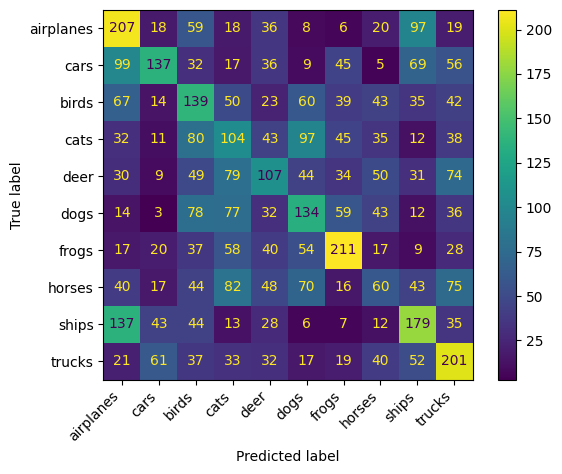

In [14]:
# Your code goes here
from skimage.feature import hog
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn import datasets, metrics, svm
import matplotlib.pyplot as plt
import numpy as np

def pca_hog_extract(X):
    X_hog = []
    for i in range(len(X)):
        fd = hog(X[i], orientations=9, pixels_per_cell=(8,8),
                  cells_per_block=(2,2), visualize=False, channel_axis=-1)
        X_hog.append(fd)
    X_hog = np.array(X_hog)

    pca = PCA(n_components=0.8)
    X_pca = pca.fit_transform(X_hog)
    return X_pca

X_train = pca_hog_extract(trainset.data.copy())
X_test = pca_hog_extract(testset.data.copy())

y_train = trainset.targets.copy()
y_test = testset.targets.copy()

svm_clf = svm.SVC(C=10, cache_size=5000)
svm_clf.fit(X_train, y_train)

y_test_predict = svm_clf.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_test_predict) * 100:.2f}")

svm_cm = confusion_matrix(y_test, y_test_predict)
disp = ConfusionMatrixDisplay(svm_cm, display_labels=['airplanes', 'cars', 'birds', 'cats', 'deer', 'dogs', 'frogs', 'horses', 'ships', 'trucks'])
disp.plot()
plt.xticks(rotation=45, ha='right')
plt.show()

# Question 3 (Expected) - Gaussian Naive Bayes Classifier

Repeat the training and evaluation of the mini-CIFAR-10 dataset using the Gaussian Naive Bayes
classifier from scikit-learn: [Gaussian Naive Bayes](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html)
Similarly report on the classification accuracy and confusion matrix.

Accuracy: 33.78


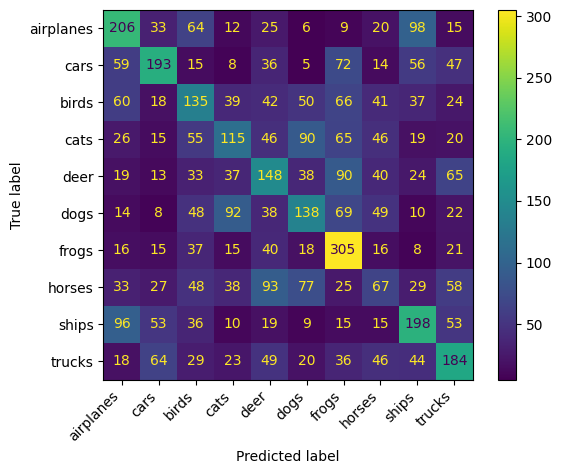

In [15]:
# YOUR CODE GOES HERE
from sklearn.naive_bayes import GaussianNB

gaussian_clf = GaussianNB()
gaussian_clf.fit(X_train, y_train)

y_test_predict = gaussian_clf.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_test_predict) * 100:.2f}")

gaussian_cm = confusion_matrix(y_test, y_test_predict)
disp = ConfusionMatrixDisplay(gaussian_cm, display_labels=['airplanes', 'cars', 'birds', 'cats', 'deer', 'dogs', 'frogs', 'horses', 'ships', 'trucks'])
disp.plot()
plt.xticks(rotation=45, ha='right')
plt.show()

 # Question 4 (Expected) - Sort classes by prediction accuracy

Write a function that takes as input the computed confusion matrix and returns a list of classes sorted by classification accuracy. Each item in the list should be a tuple of the form (class, accuracy). Show the outpput for the SVM and Gaussian NB classifiers for the mini CIFAR-10 dataset.


In [4]:
# Your answer goes here
def print_results(results):
  for pair in results:
    print(f"{pair[0]}: {pair[1]}")

def sort_by_accuracy(cm):
  rows, cols = cm.shape
  classes = {'airplanes': 0, 'cars': 0, 'birds': 0, 'cats': 0, 'deer': 0,
             'dogs': 0, 'frogs': 0, 'horses': 0, 'ships': 0, 'trucks': 0}

  class_instances = 0
  for i in range(rows):
    predicted_correctly = cm[i, i]
    for j in range(cols):
      class_instances += cm[i, j]
    accuracy = f"{((predicted_correctly / class_instances) * 100):.2f}%"
    # Get the keys of our dictionary, and access each class depending on the row
    classes[list(classes.keys())[i]] = accuracy
    # Reset the current count, since we're now dealing with another class
    class_instances = 0

  descending_order = sorted(classes.items(), key=lambda x: x[1], reverse=True)
  return descending_order

svm_results = sort_by_accuracy(svm_cm)
print("SVM Results:")
print_results(svm_results)

gaussian_results = sort_by_accuracy(gaussian_cm)
print("\nGaussian Results:")
print_results(gaussian_results)

SVM Results:
frogs: 42.97%
airplanes: 42.42%
trucks: 39.18%
ships: 35.52%
dogs: 27.46%
birds: 27.15%
cars: 27.13%
deer: 21.10%
cats: 20.93%
horses: 12.12%

Gaussian Results:
frogs: 62.12%
airplanes: 42.21%
ships: 39.29%
cars: 38.22%
trucks: 35.87%
deer: 29.19%
dogs: 28.28%
birds: 26.37%
cats: 23.14%
horses: 13.54%


# Question 5 (Expected) - Show misclassification examples  

Write a function that takes as input a particular class (for example dog) and shows an array
of images (similar to the functions showing images in the deep learning notebook) in which each row contains 10 example images from another class that were misclassified. The resulting grid will have 9 rows (one for each class other than the input class) and 10 examples. For example the row for truck would have images of trucks that were misclassified as dogs. Show the output of this function for the SVM classifier and the class horse.





Misclassifications for: horse


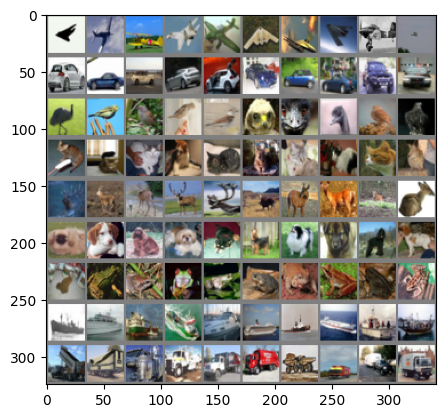

In [5]:
# Your answer goes here
import torchvision.transforms as transforms

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def plot_misclassifications(clf, input_class):
    y_test_predict = clf.predict(X_test)
    y_test_vals = np.array(y_test)

    all_classes = list(range(10))
    all_classes.remove(input_class)

    all_images = []

    print(f"Misclassifications for: {classes[input_class]}")
    for i in all_classes:
      misclassified_indices = np.where((y_test_vals == i) & (y_test_predict != y_test_vals))[0][:10]
      misclassified_indices = torch.tensor(misclassified_indices)

      dataloader = torch.utils.data.DataLoader(testset, batch_size=10, shuffle=False,
                                          sampler=torch.utils.data.SubsetRandomSampler(misclassified_indices))

      dataiter = iter(dataloader)
      images, labels = next(dataiter)

      all_images.append(torchvision.utils.make_grid(images, nrow=10))
    combined_grid = torch.cat(all_images, dim=1)
    imshow(combined_grid)

plot_misclassifications(svm_clf, input_class=7)

# Question 6 (Expected) - Comparison of different features

In the deep learning notebook the CIFAR-10 classification code using SVM utilizes a histogram of oriented gradients features followed by a PCA transformation for dimensionality reduction.
Using the mini-CIFAR-10 dataset compare the following three feature front-ends using SVM classificaiton (use the same parameters as the deep learning notebook):

1. Flatten the training images to a single (32 * 32 * 3) vector
2. Compute the Histogram of Gradients
3. Computer the Histogram of Gradients followed by PCA (as done in the deep learning notebook).

Compare these three feature front ends by showing the corresponding classification accurarcy and confusion matrices for each one.


1. Flatten the training images to a single vector:
Accuracy: 45.28


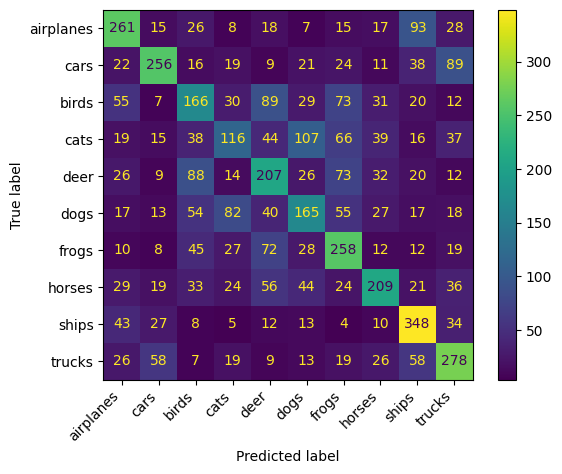


2. Compute the Histograms of Gradients
Accuracy: 55.70


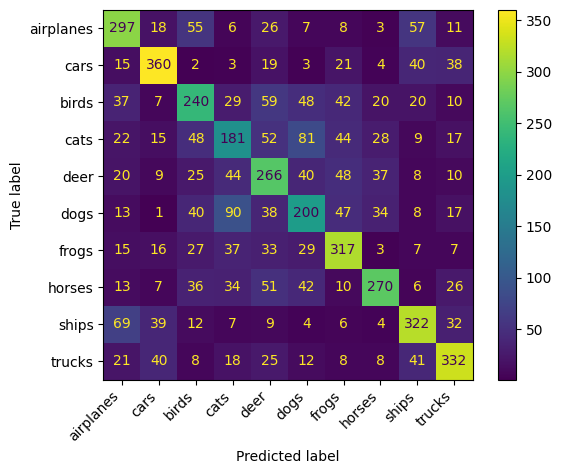


3. Compute the Histogram of Gradients followed by PCA
Accuracy: 31.78


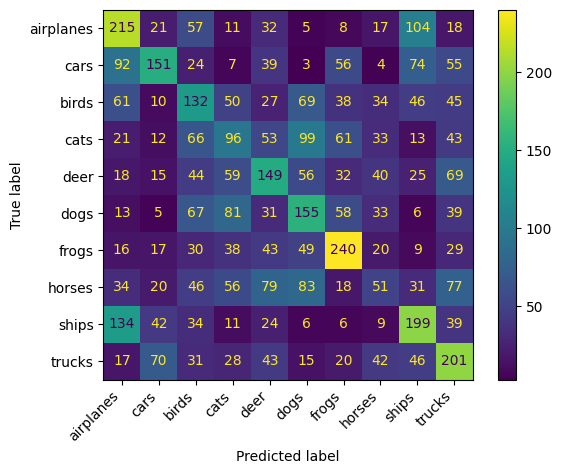

In [11]:
# Your code goes here
def hog_extract(X):
    X_hog = []
    for i in range(len(X)):
        fd = hog(X[i], orientations=9, pixels_per_cell=(8,8),
                  cells_per_block=(2,2), visualize=False, channel_axis=-1)
        X_hog.append(fd)
    X_hog = np.array(X_hog)
    return X_hog

def display_confusion_matrix(Y):
  svm_cm = confusion_matrix(y_test, Y)
  disp = ConfusionMatrixDisplay(svm_cm, display_labels=['airplanes', 'cars', 'birds', 'cats', 'deer', 'dogs', 'frogs', 'horses', 'ships', 'trucks'])
  disp.plot()
  plt.xticks(rotation=45, ha='right')
  plt.show()

print(f"1. Flatten the training images to a single vector:")
X_train_flatten = X_train.reshape((X_train.shape[0], -1))
X_test_flatten = X_test.reshape((X_test.shape[0], -1))

svm_clf_flatten = svm.SVC()
svm_clf_flatten.fit(X_train_flatten, y_train)

y_predict_flatten = svm_clf_flatten.predict(X_test_flatten)
print(f"Accuracy: {accuracy_score(y_test, y_predict_flatten) * 100:.2f}")
display_confusion_matrix(y_predict_flatten)

print(f"\n2. Compute the Histograms of Gradients")
X_train = trainset.data.copy()
X_test = testset.data.copy()

X_train_hog = hog_extract(X_train)
X_test_hog = hog_extract(X_test)

svm_clf_hog = svm.SVC()
svm_clf_hog.fit(X_train_hog, y_train)

y_predict_hog = svm_clf_hog.predict(X_test_hog)
print(f"Accuracy: {accuracy_score(y_test, y_predict_hog) * 100:.2f}")
display_confusion_matrix(y_predict_hog)

print(f"\n3. Compute the Histogram of Gradients followed by PCA")
X_train = trainset.data.copy()
X_test = testset.data.copy()

X_train_pca_hog = pca_hog_extract(X_train)
X_test_pca_hog = pca_hog_extract(X_test)

svm_clf_pca_hog = svm.SVC()
svm_clf_pca_hog.fit(X_train_pca_hog, y_train)

y_predict_pca_hog = svm_clf_pca_hog.predict(X_test_pca_hog)
print(f"Accuracy: {accuracy_score(y_test, y_predict_pca_hog) * 100:.2f}")
display_confusion_matrix(y_predict_pca_hog)

# QUESTION 7 (Basic) - Deep learning classification  

Retrain the deep neural network specified in the deep learning notebook. You will need to install PyTorch for your system. You don't need to use the GPU unless you have one and can set it up.
Your training time will depend on your hardware on my laptop with CPU it takes about 4 minutes and with GPU about 2 minutes. It should not be more than 30 minutes even on an old slow laptop. Another option is to use Google Colab.

Once you have trained and evaluated the network and got numbers similar to the deep learning notebook change the batch size to 16. Repeat the training and report on how the accuracy and training time changed.



In [7]:
# Your code goes here

# QUESTION 8 (EXPECTED) - Deep learning classification of noisy images

In this question you will explore the effect of adding noise to the classification of the CIFAR-10 dataset. You can add random noise with a mean of 0 and standard deviation of 1 to a tensor using the *torch.randn*. For example: x = x + torch.randn(x.shape) will add noise to the tensor x.
Add noise with a mean of 0 and a standard deviation of 0.2 to the images of the CIFAR-10 dataset. First see how the images with the added noise will look by adding the noise in the *imshow* function. Then check how the classification accuracy on the test set is affected if you add noise to the test but NOT the training set.


In [8]:
# Your code goes here

# QUESTION 9 (ADVANCED) - Synthetic generation of dataset



This question is a bit more open ended, will require some creativity and extra work.
Your goal is to generate a synthetic dataset of shapes. Below is some code for generating
some shapes with matplotlib. Your code should generate random shape using uniform random distributions along the following "dimensions": shape (square, circle, triangle, rhombus),
color (red, green, blue, yellow, orange, black), size (continuous but should fit in the image),
x-position (continuous but should fit in the image), y_position (continuous but should fit in the image). Once you create a plot you will need to figure out how to convert it to an image. All your images should be 64 by 64 which is bigger than the CIFAR-10 images. Generate a dataset that has 6000 instances of each shape, and 1000 instances of each color within each shape. Show some sample images by appropriately calling/modifying if needed the imshow() function from the deep learning notebook.





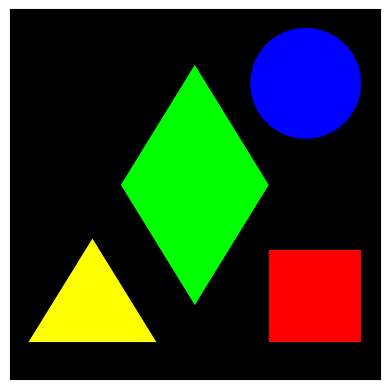

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon, Circle, Rectangle

red, blue, yellow, green = '#ff0000', '#0000ff', '#ffff00', '#00ff00'
square = Rectangle((0.7, 0.1), 0.25, 0.25, facecolor=red)
circle = Circle((0.8, 0.8), 0.15, facecolor=blue)
triangle = Polygon(((0.05,0.1), (0.396,0.1), (0.223, 0.38)), fc=yellow)
rhombus = Polygon(((0.5,0.2), (0.7,0.525), (0.5,0.85), (0.3,0.525)),  fc=green)

fig = plt.figure()
ax = fig.add_subplot(111, facecolor='k', aspect='equal')
for shape in (square, circle, triangle, rhombus):
    ax.add_artist(shape)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

plt.show()

# QUESTION 10 (ADVANCED) - Deep learning for the synthetic shapes

Using the deep learning notebook code as a template build a traditional machine learning classifier using Histogram-of-Oriented Gradients features followed by PCA and using a SVM as a classifier. Train classifiers for the following 3 problems: classify shape (irrespective of color), classify color (irrespective of shape), or classify both color and shape (you can train two SVMs one for each problem). Then repeat the same three configurations using a deep learning neural network.
Report on the classification accuracy and confusion matrices for all 6 configurations (shape-SVM, color-SVM, shape+color SVM, shape-DNN, color-DNN, shape+color DNN).


